<a href="https://colab.research.google.com/github/mara-werils/karyotype-analysis/blob/main/%D0%9A%D0%B0%D1%80%D0%B8%D0%BE%D1%82%D0%B8%D0%BF_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ultralytics torch torchvision opencv-python pandas numpy matplotlib

import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
from google.colab import drive

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/54816'
os.chdir(dataset_path)

print("Содержимое dataset:")
for item in os.listdir('.'):
    print(item)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive
Содержимое dataset:
train.txt
test.txt
diff_image.txt
Readme.txt
number_abnormalities.csv
structural_abnormalities.csv
normal.csv
weight
single_chromosomes_object
24_chromosomes_object
karyotype_data.yaml
data_24_chromosomes.yaml
data_single_chromosome.yaml
yolov8n.pt
runs


In [20]:
def analyze_dataset():
    print("Анализ структуры данных")

    folders = ['24_chromosomes_object', 'single_chromosomes_object', 'weight']
    for folder in folders:
        if os.path.exists(folder):
            print(f"{folder}: найдено")
            print(os.listdir(folder))
        else:
            print(f"{folder}: не найдено")

    meta_files = ['normal.csv', 'structural_abnormalities.csv']
    for file in meta_files:
        if os.path.exists(file):
            df = pd.read_csv(file)
            print(f"{file}: {df.shape}")

analyze_dataset()

Анализ структуры данных
24_chromosomes_object: найдено
['annotations', 'JEPG']
single_chromosomes_object: найдено
['anntations', 'JEPG']
weight: найдено
['best-24_chromosomes.pt', 'best_single_chromosomes.pt']
normal.csv: (4893, 3)
structural_abnormalities.csv: (50, 3)


Проверка изображений
Изображений 24 хромосом: 5000


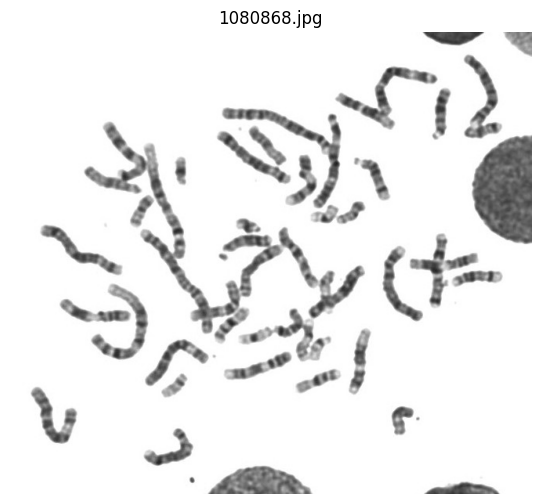

In [21]:
def check_images():
    print("Проверка изображений")

    jpeg_path_24 = '24_chromosomes_object/JEPG'
    if os.path.exists(jpeg_path_24):
        images_24 = [f for f in os.listdir(jpeg_path_24) if f.endswith('.jpg')]
        print(f"Изображений 24 хромосом: {len(images_24)}")

        if images_24:
            sample_img = cv2.imread(os.path.join(jpeg_path_24, images_24[0]))
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
            plt.title(images_24[0])
            plt.axis('off')
            plt.show()

check_images()

In [22]:
def check_annotations():
    print("Проверка аннотаций")

    import xml.etree.ElementTree as ET

    ann_path_24 = '24_chromosomes_object/annotations'
    if os.path.exists(ann_path_24):
        ann_files = [f for f in os.listdir(ann_path_24) if f.endswith('.xml')]
        print(f"Аннотаций: {len(ann_files)}")

        if ann_files:
            sample_ann = os.path.join(ann_path_24, ann_files[0])
            tree = ET.parse(sample_ann)
            root = tree.getroot()

            objects = root.findall('object')
            print(f"Объектов в аннотации: {len(objects)}")

            for i, obj in enumerate(objects[:3]):
                name = obj.find('name').text
                print(f"Объект {i+1}: {name}")

check_annotations()

Проверка аннотаций
Аннотаций: 5004
Объектов в аннотации: 46
Объект 1: A1
Объект 2: A1
Объект 3: A2


In [23]:
def create_yolo_config():
    print("Создание конфигураций YOLO")

    yaml_24 = """
path: /content/drive/MyDrive/54816
train: 24_chromosomes_object/JEPG
val: 24_chromosomes_object/JEPG

nc: 24
names: ['A1', 'A2', 'A3', 'B4', 'B5', 'B6', 'B7', 'C8', 'C9', 'C10', 'C11', 'C12',
        'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
"""

    with open('data_24_chromosomes.yaml', 'w') as f:
        f.write(yaml_24)

    single_path = 'single_chromosomes_object/JEPG'
    if os.path.exists(single_path):
        yaml_single = """
path: /content/drive/MyDrive/54816
train: single_chromosomes_object/JEPG
val: single_chromosomes_object/JEPG

nc: 1
names: ['chromosome']
"""
        with open('data_single_chromosome.yaml', 'w') as f:
            f.write(yaml_single)
        print("data_single_chromosome.yaml создан")

    print("data_24_chromosomes.yaml создан")

create_yolo_config()

Создание конфигураций YOLO
data_single_chromosome.yaml создан
data_24_chromosomes.yaml создан


In [24]:
def create_models():
    print("Создание моделей YOLO")

    model_24 = YOLO('yolov8n.pt')

    if os.path.exists('data_single_chromosome.yaml'):
        model_single = YOLO('yolov8n.pt')
    else:
        model_single = None

    return model_24, model_single

model_24, model_single = create_models()
print("Модели созданы")

Создание моделей YOLO
Модели созданы


In [25]:
def analyze_abnormalities():
    print("Анализ аномалий")

    df_abnormal = pd.read_csv('structural_abnormalities.csv')
    print("Структурные аномалии:")
    print(df_abnormal.head())

    abnormal_types = df_abnormal['description (abnormal chromosome-pair)'].value_counts()
    print("Типы аномалий:")
    print(abnormal_types)

    df_normal = pd.read_csv('normal.csv')
    print(f"Нормальных случаев: {len(df_normal)}")

analyze_abnormalities()

Анализ аномалий
Структурные аномалии:
      filename  chromosome numbers description (abnormal chromosome-pair)
0  1050761.jpg                  46                                      8
1  1050762.jpg                  46                                      8
2  1050763.jpg                  46                                      8
3  1050764.jpg                  46                                      8
4  1056995.jpg                  46                                   8,17
Типы аномалий:
description (abnormal chromosome-pair)
9         10
X          8
14         5
8          4
2          4
11         4
15         3
3,15       2
8,21       2
13         2
8,17       1
2,3,11     1
2,5        1
2,11       1
2,14       1
3,13       1
Name: count, dtype: int64
Нормальных случаев: 4893


In [6]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

def create_yolo_structure():
    print("Создание структуры данных для YOLO")

    images_path = '24_chromosomes_object/JEPG'
    annotations_path = '24_chromosomes_object/annotations'

    if not os.path.exists(images_path) or not os.path.exists(annotations_path):
        print("Ошибка: не найдены папки с изображениями или аннотациями")
        return

    yolo_dir = 'yolo_dataset'
    os.makedirs(f'{yolo_dir}/images/train', exist_ok=True)
    os.makedirs(f'{yolo_dir}/images/val', exist_ok=True)
    os.makedirs(f'{yolo_dir}/labels/train', exist_ok=True)
    os.makedirs(f'{yolo_dir}/labels/val', exist_ok=True)

    class_names = ['A1', 'A2', 'A3', 'B4', 'B5', 'B6', 'B7', 'C8', 'C9', 'C10', 'C11', 'C12',
                   'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
    class_to_id = {name: idx for idx, name in enumerate(class_names)}

    image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    def process_files(files, split):
        for img_file in files:
            base_name = os.path.splitext(img_file)[0]
            xml_file = os.path.join(annotations_path, base_name + '.xml')

            if not os.path.exists(xml_file):
                continue

            shutil.copy(os.path.join(images_path, img_file), f'{yolo_dir}/images/{split}/{img_file}')

            tree = ET.parse(xml_file)
            root = tree.getroot()

            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)

            label_lines = []
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in class_to_id:
                    continue

                class_id = class_to_id[class_name]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                x_center = (xmin + xmax) / 2 / width
                y_center = (ymin + ymax) / 2 / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                label_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

            if label_lines:
                with open(f'{yolo_dir}/labels/{split}/{base_name}.txt', 'w') as f:
                    f.write('\n'.join(label_lines))

    process_files(train_files, 'train')
    process_files(val_files, 'val')

    print(f"Создано {len(train_files)} тренировочных и {len(val_files)} валидационных изображений")

    with open(f'{yolo_dir}/data.yaml', 'w') as f:
        f.write(f"path: {os.path.abspath(yolo_dir)}\n")
        f.write("train: images/train\n")
        f.write("val: images/val\n\n")
        f.write(f"nc: {len(class_names)}\n")
        f.write(f"names: {class_names}\n")

    print("YOLO структура создана")

create_yolo_structure()

Создание структуры данных для YOLO
Создано 4000 тренировочных и 1000 валидационных изображений
YOLO структура создана


In [7]:
from ultralytics import YOLO

def train_model():
    print("Обучение модели")

    model = YOLO('yolov8n.pt')

    results = model.train(
        data='yolo_dataset/data.yaml',
        epochs=10,
        imgsz=640,
        batch=16,
        workers=4,
        patience=5,
        device='cuda'
    )

    return results

train_model()

Обучение модели
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797fb137c920>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042, 


image 1/1 /content/drive/MyDrive/54816/yolo_dataset/images/val/1071614.jpg: 640x576 2 A1s, 3 A2s, 4 A3s, 3 B4s, 1 B5, 2 C8s, 3 C9s, 2 C10s, 2 C11s, 1 C12, 4 D13s, 2 D14s, 5 D15s, 3 E16s, 4 E17s, 3 E18s, 2 F19s, 1 F20, 2 G21s, 2 G22s, 2 Xs, 2 Ys, 65.8ms
Speed: 6.1ms preprocess, 65.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)


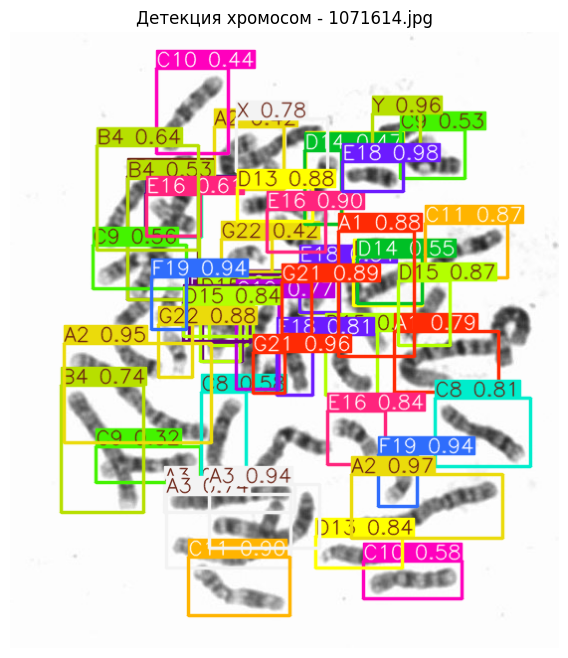


image 1/1 /content/drive/MyDrive/54816/yolo_dataset/images/val/1057513.jpg: 640x608 3 A1s, 3 A2s, 2 A3s, 4 B4s, 1 B5, 2 C8s, 1 C9, 3 C10s, 3 C11s, 3 D13s, 1 D14, 3 D15s, 2 E16s, 3 E17s, 3 E18s, 4 F19s, 3 F20s, 2 G21s, 3 Xs, 128.4ms
Speed: 7.0ms preprocess, 128.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


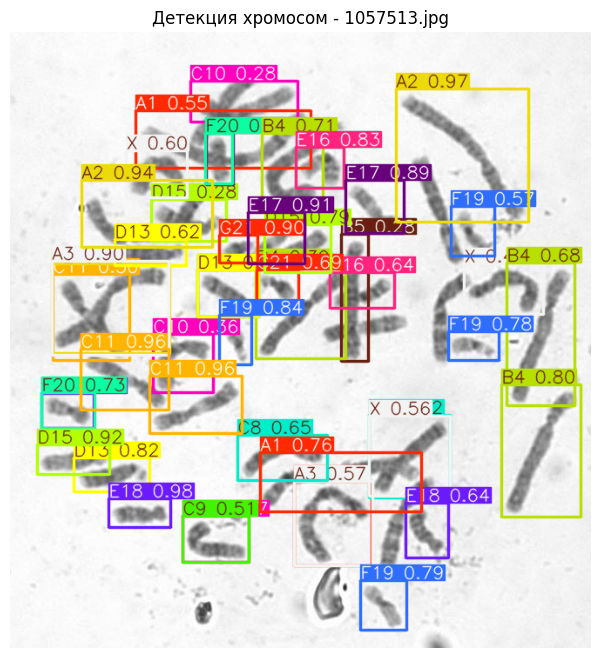


image 1/1 /content/drive/MyDrive/54816/yolo_dataset/images/val/1057641.jpg: 640x544 3 A1s, 2 A2s, 4 A3s, 2 B4s, 4 B5s, 3 C8s, 4 C11s, 3 D13s, 1 D14, 3 D15s, 2 E16s, 2 E17s, 1 E18, 3 F19s, 2 F20s, 3 G21s, 3 G22s, 3 Xs, 82.1ms
Speed: 35.4ms preprocess, 82.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


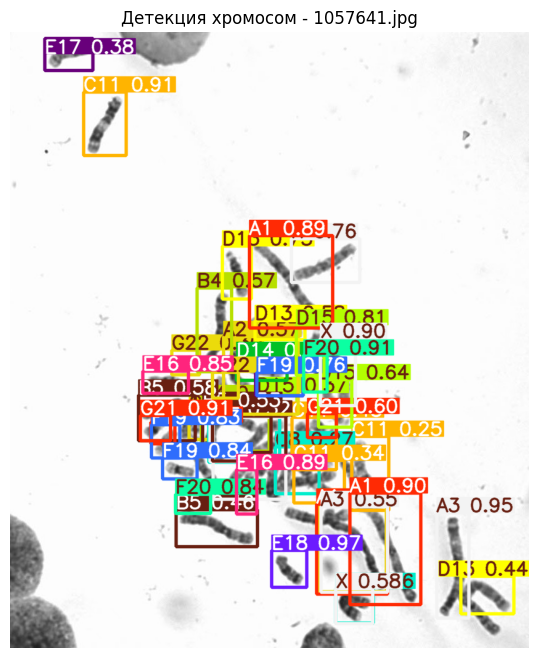


image 1/1 /content/drive/MyDrive/54816/yolo_dataset/images/val/1060741.jpg: 640x576 6 A1s, 3 A2s, 3 A3s, 2 B4s, 1 B5, 2 C8s, 2 C10s, 3 C11s, 2 C12s, 6 D13s, 2 D14s, 4 D15s, 3 E16s, 2 E17s, 1 E18, 2 F19s, 3 F20s, 2 G21s, 1 G22, 1 X, 9.7ms
Speed: 4.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


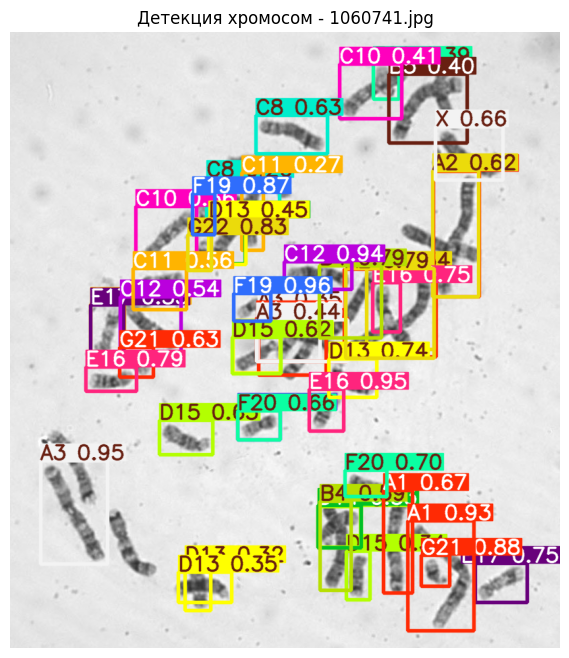


image 1/1 /content/drive/MyDrive/54816/yolo_dataset/images/val/1100927.jpg: 544x640 2 A1s, 3 A2s, 1 A3, 1 B4, 2 B5s, 1 C8, 3 C9s, 2 C10s, 5 C11s, 1 C12, 2 D13s, 1 D14, 2 D15s, 3 E16s, 3 E17s, 3 E18s, 1 F19, 4 F20s, 2 G21s, 3 Xs, 1 Y, 59.1ms
Speed: 4.2ms preprocess, 59.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


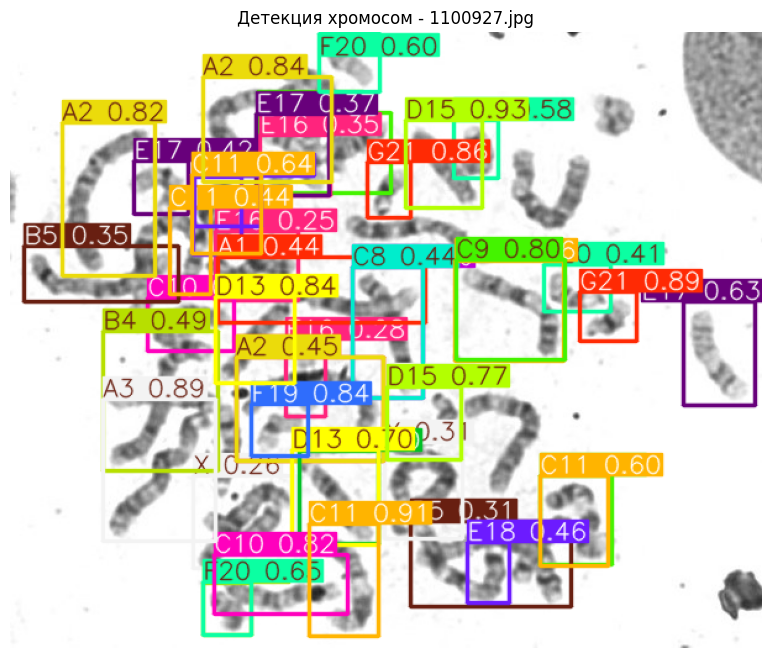

In [8]:
def visualize_predictions():
    model = YOLO('runs/detect/train2/weights/best.pt')

    test_images = os.listdir('yolo_dataset/images/val')[:5]

    for img_name in test_images:
        img_path = f'yolo_dataset/images/val/{img_name}'
        results = model(img_path)

        for r in results:
            im_array = r.plot()
            plt.figure(figsize=(12, 8))
            plt.imshow(im_array)
            plt.title(f'Детекция хромосом - {img_name}')
            plt.axis('off')
            plt.show()

visualize_predictions()